# Inclusión de bilbiotecas y set de imagenes

In [ ]:
#Se va a agregar el drive al entorno para poder mover archivos más facilmente
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Inclusión de set de imagenes y las etiquetas


Se tienen dos opciones para subir las imagenes y las etiquetas a la nuve

La primera opción es descargar directamente del link dado en el github y subirlas como un archivo zip y agregarlos a la nube como se muestra a continuación:

In [ ]:
#Para facilidad se sugiere subir al drive personal el DataSet de los Simpsons en un zip y descomprimirlo en ruta aquí
#Este pesa cerca de 1GB pero no va a consumir más memoria que eso

#Instruccion cp de copiado, se sigue de la direccion en la que se tiene el zip con los datos
#y se copia directamente en ./content con el mismo nombre
#Para este ejemplo, el nombre del zip es "Images_Simpsons.zip"
!cp /content/drive/'My Drive'/CoffeeCoffee/Images_Simpsons.zip Images_Simpsons.zip
print('Copy done!')

#Instruccion unzip para descomprimir -qq es la opción de silenciar salida, así no hay tanto ruido
!unzip -qq Images_Simpsons.zip
print('Unzip done!')

Copy done!
Unzip done!


La segunda opción es descargarlos directamente desde el link de dropbox que se da a continuación, aunque esta opción no se recomienda si se ha hecho modificaciones al set de datos.

In [1]:
#Descarga directamente el set de datos y etiquetas
!wget -c -qq https://www.dropbox.com/s/q2nu20ucnpergu3/Images_Simpsons.zip
print('Copy done!')

#Instruccion unzip para descomprimir -qq es la opción de silenciar salida, así no hay tanto ruido
!unzip -qq Images_Simpsons.zip
print('Unzip done!')

Copy done!


'wget' is not recognized as an internal or external command,
operable program or batch file.


Unzip done!


'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Inclusión de bibliotecas

In [ ]:
#Se importan las bibliotecas. En caso de querer hacer este proceso directamente
#en un ordenador se deben instalar las bilbiotecas que se indican a continuacion:

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import h5py
import sklearn
import glob
import keras
import time
import imp
import os
import tensorflow as tf 
import pandas as pd

#Estas bibliotecas no son necesarias en su totalidad, solo se requieren ciertas
#funciones
from random import shuffle
from skimage import io
from collections import Counter
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

#Importe de funciones especificas de bibliotecas ya importadas
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam

#lineas requeridas solo en jupyter notbook
%matplotlib inline
%tensorflow_version 2.x

Using TensorFlow backend.


# Manejo de datos, entrenamiento y pruebas

## Lectura y preprocesado de datos

In [ ]:
#Se inicia definiendo el diccionario map_characters, este posee originalmente 18
#personajes, si se agrega otro más se debe agregar al diccionario y colocarsele 
#el número consecutivo que corresponda
map_characters = {0: 'abraham_grampa_simpson', 
                  1: 'apu_nahasapeemapetilon', 
                  2: 'bart_simpson',
                  3: 'charles_montgomery_burns', 
                  4: 'chief_wiggum', 
                  5: 'comic_book_guy', 
                  6: 'edna_krabappel', 
                  7: 'homer_simpson', 
                  8: 'kent_brockman', 
                  9: 'krusty_the_clown', 
                  10: 'lisa_simpson', 
                  11: 'marge_simpson', 
                  12: 'milhouse_van_houten', 
                  13: 'moe_szyslak', 
                  14: 'ned_flanders', 
                  15: 'nelson_muntz', 
                  16: 'principal_skinner', 
                  17: 'sideshow_bob',
                  18: 'maggie_simpson'}
                  
#Se define el numero de clases con la extensión del diccionario
num_classes = len(map_characters)

#Número máximo de imagenes que se usaran por personaje para entrenar
pictures_per_class = 1000

def load_pictures(test_size, pic_size,BGR):
    """
    Load pictures from folders for characters from the map_characters dict and create a numpy dataset and 
    a numpy labels set. Pictures are re-sized into picture_size square.
    :param BGR: boolean to use true color for the picture (RGB instead of BGR for plt)
    :return: dataset, labels set
    """
    pics = []    #Se crea la lista de imagenes de salida
    labels = []  #Se crea la lista de etiquetas de salida

    #k es el numero de la variable en el diccionario
    #char es el nombre de la variable en el diccionario
    # El if lo que hace es que recorra cada una de las variables del diccionario
    for k, char in map_characters.items(): 

        #Esta linea deivuelve la lista de rutas de las imagenes de cada personaje del diccionario
        # Ej: para char = 'abraham_grampa_simpson' regresa todas las rutas de imagen de la carpeta
        # abraham_grampa_simpson que a su vez esta en la carpeta characters.
        #Es solo una forma elegante y rapida de optener todas las rutas 
        pictures = [k for k in glob.glob('./characters/%s/*' % char)]

        #Se establece la cantidad de imagenes que se van a usar en cada clase
        #Como maximo se usan 1176 imagenes, estas son tanto para train como para test
        #Si el personaje en particular tiene menos de 1176 imagenes se usara la extension del personaje en cuestion
        nb_pic = round(pictures_per_class/(1-test_size)) if round(pictures_per_class/(1-test_size))<len(pictures) else len(pictures)

        #Se usa la funcion random para ordenar de manera aleatoria las imagenes de cada personaje
        #Cabe detacar que pic es una ruta de acceso aleatoria de la lista de rutas de acceso en pictures
        for pic in np.random.choice(pictures, nb_pic):

            #Se lee la imagen de la ruta "pic"
            a = cv2.imread(pic)

            #Si se desea se usa RGB se hace la transformacion de BGR, que es la lectura original
            #Por defecto este cambio no se hace a menos que se especifique
            if BGR:
                a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
            
            #Se hace un resize de las imagenes a pic_size x pic_size. Por defecoto
            #este es 64x64. Esto concuerda con los pixeles de entrada de la red neuronal
            a = cv2.resize(a, (pic_size,pic_size))

            #Se agrega la imagen leida, convertida y escalada a la lista pics
            pics.append(a)
            #Se agrega la etiqueta numérica de la lista de etiquetas, esta etiqueta numerica 
            #concuerda con el número en el diccionario map_characters
            labels.append(k)

    #Se devuelve las listas pero antes se transforman a un formato de array con numpy
    return np.array(pics), np.array(labels) 

def get_dataset(save=False, load=False, BGR=False, test_size=0.15, pic_size=64):
    """
    Create the actual dataset split into train and test, pictures content is as float32 and
    normalized (/255.). The dataset could be saved or loaded from h5 files.
    :param save: saving or not the created dataset
    :param load: loading or not the dataset
    :param BGR: boolean to use true color for the picture (RGB instead of BGR for plt)
    :return: X_train, X_test, y_train, y_test (numpy arrays)
    """
    #Si ya se tienen listos de antemano se cargan directamente de memoria, por 
    #defecto esta opcion esta desactivada
    if load:
        #Se lee directamente el archivo 'dataset.h5', aqui estan tanto el set de 
        #entrenamiento como el de test 
        h5f = h5py.File('dataset.h5','r')
        
        #Se divide entre set de train y set de test, esto gracias a la etiqueta
        #que el archivo .h5 trae, similar a un formato .json
        X_train = h5f['X_train'][:]
        X_test = h5f['X_test'][:]
        h5f.close()

        #Se hace un proceso igual pero para los labels
        h5f = h5py.File('labels.h5','r')
        y_train = h5f['y_train'][:]
        y_test = h5f['y_test'][:]
        h5f.close()    
    
    #En caso de que no esten en memoria los sets de entrenamiento y test se 
    #realiza todo el procesamiento desde cero
    else:
        #Primero se llama a la funcion load_pictures, por defecto se deja estas en 
        #blanco y negro
        #En esta funcion tambien se extraen los labels del archivo txt anotations
        X, y = load_pictures(test_size, pic_size, BGR)

        #Luego se pasa los labels a un formato numerico y en listas separadas,
        #por ejemplo si el label es 2 to_categorical lo pasa a una lista [0 0 1 ... 0]
        #El tamaño de la lista depende de cuantas clases se tenga, en este ejemplo son 18
        y = keras.utils.to_categorical(y, num_classes)

        #Posteriormente se divide todos los datos en set de train y test, el tamaño del
        #set de test esta dado por la variable test_size, por defecto es 15%
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        
        #Se guarda los sets creados en archivos con formato .h5, tanto los labels como
        #las imagenes
        if save:
            h5f = h5py.File('dataset.h5', 'w')
            h5f.create_dataset('X_train', data=X_train)
            h5f.create_dataset('X_test', data=X_test)
            h5f.close()

            h5f = h5py.File('labels.h5', 'w')
            h5f.create_dataset('y_train', data=y_train)
            h5f.create_dataset('y_test', data=y_test)
            h5f.close()

    #Se normaliza las imagenes para que los valores de cada banda esten en punto flotante
    #y además se encuentren entre 0 y 1. Esto ayuda a la velocidad de entrenamiento           
    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.
    
    #Se imprime las formas de cada tensor. Si se mantienen todas las variables 
    #por defecto estas deben ser (x,64,64,3) y (x,w), donde x es el numero de imagenes
    #y w es la cantidad de clases en el diccionario
    print("Train", X_train.shape, y_train.shape)
    print("Test", X_test.shape, y_test.shape)

    #Imprime la cantidad de imagenes por personaje y la cantidad de imagenes en 
    #que se pusieron en el set de train y en el set de test
    if not load:
        #Se crea un diccionario donde cada variable esta asociada a una lista que contiene la extension del set
        #de train y test para cada personaje
        dist = {k:tuple(d[k] for d in [dict(Counter(np.where(y_train==1)[1])), dict(Counter(np.where(y_test==1)[1]))]) 
                for k in range(num_classes)}

        #Se imprime en orden decendente
        print('\n'.join(["%s : %d train pictures & %d test pictures" % (map_characters[k], v[0], v[1]) 
            for k,v in sorted(dist.items(), key=lambda x:x[1][0], reverse=True)]))
    
    #Se devuelve los set de datos divididas en train y test. Esto tanto para las 
    #imagenes como para los labels.
    return X_train, X_test, y_train, y_test

#Uso de funciones de lectura para dividir el set de imagnes en test y train
X_train, X_test, y_train, y_test = get_dataset(save=True)

Train (14426, 64, 64, 3) (14426, 19)
Test (2546, 64, 64, 3) (2546, 19)
ned_flanders : 1011 train pictures & 165 test pictures
principal_skinner : 1009 train pictures & 167 test pictures
bart_simpson : 1003 train pictures & 173 test pictures
krusty_the_clown : 1003 train pictures & 173 test pictures
lisa_simpson : 1002 train pictures & 174 test pictures
charles_montgomery_burns : 993 train pictures & 183 test pictures
homer_simpson : 992 train pictures & 184 test pictures
moe_szyslak : 983 train pictures & 193 test pictures
marge_simpson : 970 train pictures & 206 test pictures
milhouse_van_houten : 913 train pictures & 166 test pictures
chief_wiggum : 850 train pictures & 136 test pictures
abraham_grampa_simpson : 786 train pictures & 127 test pictures
sideshow_bob : 754 train pictures & 123 test pictures
apu_nahasapeemapetilon : 539 train pictures & 84 test pictures
kent_brockman : 435 train pictures & 63 test pictures
comic_book_guy : 405 train pictures & 64 test pictures
edna_krabap

## Creacion de redes neuronales (CNN)

In [ ]:
#Se tiene una red neuronal convolucional de cuatro capas convolucionales
def create_model_four_conv(input_shape):
    """
    CNN Keras model with 4 convolutions.
    :param input_shape: input shape, generally X_train.shape[1:]
    :return: Keras model, RMS prop optimizer
    """

    #Se crea primeramente un modelo "Sequential", este es el tipo de red neuronal
    #existen otros tipos como las recursivas y las recurrentes.

    model = Sequential()
    
    #Se usa mucho las capas Conv2D, por lo que se explicara solo una vez. Estas 
    #tienen el formato por defecto:
    
    #tf.keras.layers.Conv2D(
    #    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    #    dilation_rate=(1, 1), activation=None, use_bias=True,
    #    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    #    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    #    kernel_constraint=None, bias_constraint=None, **kwargs)
    #
    #Donde:
    #"filters" se refiere a la cantidad de filtros que se tienen en esa capa, 
    #por ejemplo en la primera capa se tiene 32 filtros.
    #Los filtros son los que cambuan durante el entrenamiento.
    
    #"strides" es siempre una tupla. Se refiere a las dimenciones dadas para 
    #cada filtro, por defecto esta variable tiene como valor la tupla (1,1). 
    #Por ejemplo, en la primera capa se usa una dimensión para los filtros (3,3)
    
    #"padding" es una bandera que puede ser "valid" (opcion por defecto) 
    #o "same" (case-insensitive). La opción valid tiene la posibilidad de perder
    #informacion de entrada en especial de las esquinas. Por otra parte same
    #aplica rellenos en las esquinas de modo que se usen todos los pixeles de entrada

    #"input_shape" se usa solo en la capa (layer) de entrada

    #¿Que recibe de entrada y que obtiene de salida estas capas?
    #La entrada debe ser un tensor de 4D con el formato:
    #   (batch_size, rows, cols, channels), si data_format='channels_last' esta 
    #     es la opcion por defecto de "data_format"
    #
    #   (batch_size, channels, rows, cols), si data_format='channels_first'
    #
    #La salida es otro tensor de 4D con el formato:
    #   (batch_size, new_rows, new_cols, filters), si data_format='channels_last' 
    #     esta es la opcion por defecto de "data_format"
    #
    #   (batch_size, filters, new_rows, new_cols), si data_format='channels_first' 
    #
    #rows and cols pueden variar dependiendo de la bandera "padding", con "same"
    #se tendrían la misma candtidad de rows y cols de salida que de entrada.

    #Primera capa convolucional
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))

    #Se agrega una funcion de activación, se puede agregar directamente en la capa
    #convolucional pero esto haría que se pusiera la activación en la entrada, 
    #se decide poner la activación en la salida.
    #La función de activación que se usa es la "relu" pero existen otras funciones
    #de activación, estas se pueden encontrar aqui:
    #https://www.tensorflow.org/api_docs/python/tf/keras/activations 
    #Relu hace que los valores con un valor menor a 1 se vuelvan 0
    model.add(Activation('relu'))

    #Como resultado de la primera capa convolucional se tiene 32 capas de profundidad
    #y cada una de estas capas poseen las mismas dimensiones que la imagen de entrada
    #en caso de mantener la configuracion por defecto se tiene 64x64x32, se puede 
    #ver como un cubo con tres dimensiones: largo, ancho y profundidad 

    #Segunda capa convolucional, con 32 filtros
    #Esta segunda capa sigue siendo convolucional pero notese que no posee el 
    #padding, como resultado se pierde las últimas filas y columnas (los bordes)
    #por lo que para este caso el cubo seria de dimenciones 62x62x32, ya que 
    #aún se tienen los 32 filtros. La función de activación sigue siendo "relu".
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    
    #Una capa Maxpolling2D reduce la cantidad de col y rows, en este caso
    #se reduce de una matriz 2x2 a un único escalar, como consecuencia se tiene
    #como resultado un cubo 31x31x32.
    #Los layers de pool lo que hacen es reducir la cantidad de filas y columnas
    #de entrada, esto puede hacerse por promedio, minimo, maximo o una función
    #en este caso MaxPooling lo que hace es usar el valor máximo de la matriz que
    #está viendo. (de la matriz 2x2 agarra el valor máximo y ese es el resultado)
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #Las capas dropout se usa para evitar el overfiting, estas solo se activan
    #durante el entrenamiento, y su función es hacer cero entradas de manera aleatoria
    #con un taza de ocurrencia seleccionada por el usuario (en este caso es de 25%)
    #las que no son colocadas en 0 se multiplican por 1/(1-rate)
    model.add(Dropout(0.25))

    #Tercera capa convolucional, con 64 filtros
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    
    #Cuarta capa convolucional, con 64 filtros
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #La capa "flatten" lo que hace es pasar de las capas convolucionales y 3D a 
    #capas en una dimensión. Un único vector horizontal.
    model.add(Flatten())
    
    #Se reduce la cantidad de neuronas, en este casi particular se pasa de la cantidad
    #dada por Flatten y se pasa a 512 nueronas, se recomienda siempre usar 2^n valores
    #Esta capa se le conoce como fully connected layer
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    #Finalmente se reduce a la cantidad de neuronas equivalentes a la cantidad de clases
    #que se desean, en nuestro caso, la cantidad de personajes que estamos clasificando
    model.add(Dense(num_classes))
    #"softmax" convierte el valor en probabilidad de 0 a 1.
    model.add(Activation('softmax'))
    
    #Se define la funcion de optimización
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    return model, opt


#Igual que el caso anterior pero se tiene una red de 6 capas convolucionales
def create_model_six_conv(input_shape):
    """
    CNN Keras model with 6 convolutions.
    :param input_shape: input shape, generally X_train.shape[1:]
    :return: Keras model, RMS prop optimizer
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3, 3), padding='same')) 
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    return model, opt


#Igual que el caso anterior pero se tiene una red de 8 capas convolucionales
def create_model_eight_conv(input_shape):
    """
    CNN Keras model with 8 convolutions.
    :param input_shape: input shape, generally X_train.shape[1:]
    :return: Keras model, RMS prop optimizer
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same')) 
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same')) 
    model.add(Activation('relu'))
    model.add(Conv2D(512, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(2048))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

    #opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    return model, opt

## Entrenamiento y Puebas con la red neuronal

In [ ]:
def load_model_from_checkpoint(weights_path, six_conv=False, pic_size=64):
    input_shape=(pic_size,pic_size,3)
    if six_conv:
        model, opt = create_model_six_conv(input_shape)
    else:
        model, opt = create_model_four_conv(input_shape)
    model.load_weights(weights_path)
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model

#Función para modificar el learning rate
def lr_schedule(epoch):
    lr = 0.01
    return lr*(0.7**int(epoch/10))

#Función de entrenamiento
def training(model, X_train, X_test, y_train, y_test, data_augmentation=True, epochs=400, batch_size=32):
    """
    Training.
    :param model: Keras sequential model
    :param data_augmentation: boolean for data_augmentation (default:True)
    :param callback: boolean for saving model checkpoints and get the best saved model
    :param six_conv: boolean for using the 6 convs model (default:False, so 4 convs)
    :return: model and epochs history (acc, loss, val_acc, val_loss for every epoch)
    """
    if data_augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        
        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(X_train)
        
        #Las funciones callback son funciones que se ejecutan periodicamente si 
        #se cumplen ciertas condiciones, en este caso se desea hacer un checkpoint
        #este tiene el siguiente formato:
        # tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
        #                                     verbose=0, save_best_only=False,
        #                                     save_weights_only=False, mode='auto',
        #                                     save_freq='epoch', **kwargs)

        #Se define el nombre que tendran los pesos guardados automaticamente
        filepath='best_weights.hdf5'

        #En algunas versiones de tensorflow val_accuracy se cambia por val_acc,
        #esta es la variable que define si se va a guardar o no los pesos, en caso
        #de que el acc suba o no. Este acc es del set de validación.
        checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True, mode='max')
        
        #Además del checkpoint se agrega otra funcion en callback para que se vaya
        #ejecutando el entrenamiento, esta es la funcion lr_schedule, que va
        #modificando el learning rate.
        #
        #"LearningRateScheduler" es una función de keras para modificar el learning rate
        #esta función debe recivir como entrada otra función, a la que se le ingresa la
        #epoca en la que se encuentra el entrenamiento. La documentación esta en:
        #https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler?hl=en

        callbacks_list = [LearningRateScheduler(lr_schedule) ,checkpoint]
        
        #fit(x=None,       y=None,  batch_size=None, epochs=1,    verbose=1,    callbacks=None,
        #   validation_split=0.0 , validation_data=None      , shuffle=True, class_weight=None,
        #   sample_weight=None   , initial_epoch=0           , steps_per_epoch=None,
        #   validation_steps=None, validation_batch_size=None, validation_freq=1,
        #   max_queue_size=10    , workers=1                 , use_multiprocessing=False)

        #Inicio de entrenamiento
        history = model.fit(datagen.flow(X_train, y_train,
                            batch_size=batch_size),
                            steps_per_epoch=X_train.shape[0] / batch_size,
                            epochs=epochs,
                            validation_data=(X_test, y_test),
                            callbacks= callbacks_list,
                            shuffle=True)
    else:
        #Difinicion de los callbacks, son los mismos que se usan arriba
        filepath='best_weights.hdf5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True, mode='max')
        callbacks_list = [LearningRateScheduler(lr_schedule) ,checkpoint]
        
        #Inicio de entrenamiento
        history = model.fit(X_train, y_train,
                            batch_size=batch_size,
                            steps_per_epoch=X_train.shape[0] // batch_size,
                            epochs=epochs,
                            validation_data=(X_test, y_test),
                            callbacks= callbacks_list,
                            shuffle=True)
    return model, history


In [ ]:
## Training in the notebook
epochs_num = 100
model, opt = create_model_six_conv(X_train.shape[1:])
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model, history = training(model, X_train, X_test, y_train, y_test, data_augmentation=True, epochs=epochs_num)

Epoch 1/100
451/450 [==============================] - 19s 41ms/step - loss: 2.6879 - accuracy: 0.1527 - val_loss: 2.2067 - val_accuracy: 0.3181
Epoch 2/100
451/450 [==============================] - 18s 41ms/step - loss: 2.0628 - accuracy: 0.3739 - val_loss: 1.6494 - val_accuracy: 0.4988
Epoch 3/100
451/450 [==============================] - 18s 41ms/step - loss: 1.6001 - accuracy: 0.5176 - val_loss: 1.1862 - val_accuracy: 0.6532
Epoch 4/100
451/450 [==============================] - 18s 40ms/step - loss: 1.2495 - accuracy: 0.6258 - val_loss: 0.8542 - val_accuracy: 0.7412
Epoch 5/100
451/450 [==============================] - 19s 41ms/step - loss: 1.0042 - accuracy: 0.6919 - val_loss: 0.7065 - val_accuracy: 0.7918
Epoch 6/100
451/450 [==============================] - 18s 40ms/step - loss: 0.8182 - accuracy: 0.7515 - val_loss: 0.5997 - val_accuracy: 0.8193
Epoch 7/100
451/450 [==============================] - 18s 41ms/step - loss: 0.7057 - accuracy: 0.7864 - val_loss: 0.5102 - val_ac

In [ ]:
#Se guarda el modelo y el "history" que ayuda después para documentación
pd.DataFrame.from_dict(history.history).to_csv('history.csv',index=False)
model.save('New.h5')

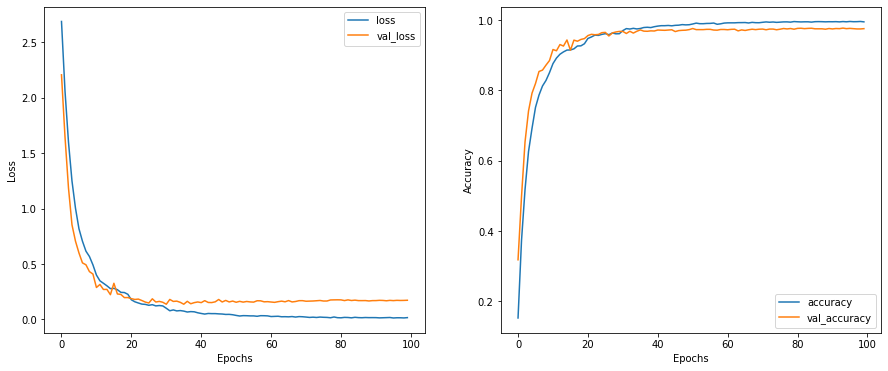

In [ ]:
#Lee el csv creado
data = pd.read_csv("history.csv")

#Se imprime la mejora de la red por epoca
epochs= range(epochs_num)
f, ax = plt.subplots(ncols=2, figsize=(15,6))
ax[0].plot(epochs, data['loss'], label='loss')
ax[0].plot(epochs, data['val_loss'], label='val_loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(epochs, data['accuracy'], label='accuracy')
ax[1].plot(epochs, data['val_accuracy'], label='val_accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

In [ ]:
from sklearn.metrics import classification_report

predictions_last_epoch = model.predict(X_test, batch_size=32, verbose=1)

Pred_y = np.argmax(predictions_last_epoch, axis=1)
True_y = np.argmax(y_test, axis=1)
target_names = list(map_characters.values())


report = classification_report(True_y, Pred_y, target_names=target_names)
print('\n')
print(report)

2546/2546 [==============================] - 1s 218us/step


                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.97      0.98      0.98       127
  apu_nahasapeemapetilon       0.99      1.00      0.99        84
            bart_simpson       0.98      0.98      0.98       173
charles_montgomery_burns       0.96      0.96      0.96       183
            chief_wiggum       0.96      0.99      0.97       136
          comic_book_guy       0.95      0.97      0.96        64
          edna_krabappel       0.98      0.96      0.97        82
           homer_simpson       0.94      0.94      0.94       184
           kent_brockman       0.98      0.98      0.98        63
        krusty_the_clown       0.99      0.99      0.99       173
            lisa_simpson       0.98      0.98      0.98       174
           marge_simpson       1.00      0.99      0.99       206
     milhouse_van_houten       0.97      0.99      0.98       166
             m

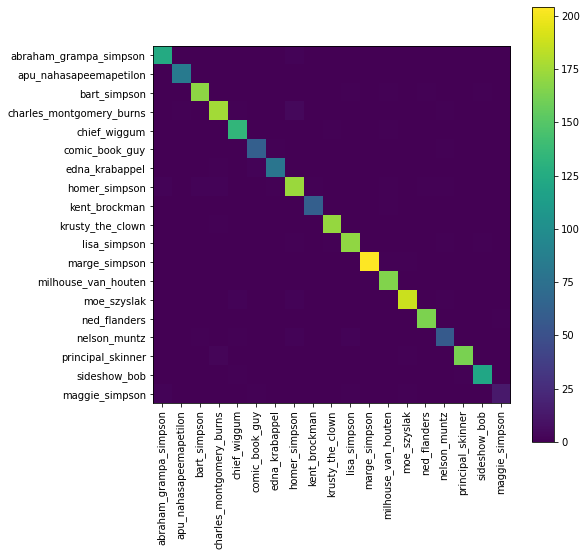

In [ ]:
plt.figure(figsize=(8,8))
cnf_matrix = sklearn.metrics.confusion_matrix(np.where(y_test > 0)[1], np.argmax(predictions_last_epoch, axis=1))
classes = list(map_characters.values())
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [ ]:
#Se carga el mejor modelo y se imprime el loss y acc con el set de test
#Crea un nuevo modelo y se le colocan los pesos guardados por el callback
#Este proceso se puede hacer tambien con la funcion load_model_from_checkpoint

input_shape=(64,64,3)
Best_model, opt = create_model_six_conv(input_shape)
Best_model.load_weights('best_weights.hdf5')
Best_model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

results = Best_model.evaluate(X_test, y_test, batch_size=128)
print('test loss, test acc:', results)

2546/2546 [==============================] - 1s 490us/step
test loss, test acc: [0.19306286774686912, 0.9721131324768066]


In [ ]:
#Se usa el modelo final y se imprime el loss y acc con el set de test
#Esto para comparar los resultados del modelo final y el mejor modelo

results = model.evaluate(X_test, y_test, batch_size=128)
print('test loss, test acc:', results)

2546/2546 [==============================] - 1s 316us/step
test loss, test acc: [0.19118716169180874, 0.9701492786407471]


In [ ]:
#Explicación de como cargar directamente el modelo final guardado manualmente 
!cp /content/drive/'My Drive'/CoffeeCoffee/New.h5  New.h5
new_model = keras.models.load_model('New.h5')

#Summary nos dice la arquitectura de la red neuronal
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_15 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_16 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 31, 31, 64)       

In [ ]:
#Guardado de resultados en drive personal para poder usarlos después de que la sesión finalice
!cp best_weights.hdf5 /content/drive/'My Drive'/CoffeeCoffee/best_weights.hdf5
!cp New.h5 /content/drive/'My Drive'/CoffeeCoffee/New.h5
!cp history.csv /content/drive/'My Drive'/CoffeeCoffee/history.csv

##Predicciones Manuales

In [ ]:
def plot_and_predict(image, model, BGR=False, pic_size=64 ,all_perc=False):
    pics = []
    img = io.imread(image)
    plt.imshow(img)
    plt.show()
    
    #Lectura de la imagen con OpenCV
    a = cv2.imread(image)

    #Esto es importante, si se entreno en blanco y negro se debe hacer la lectura
    #en blanco y negro, por defecto esta en blanco y negro BGR = False
    if BGR:
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    #Se hace el resize a pic_size x pic_size por defecto esto es 64x64 
    a = cv2.resize(a, (pic_size,pic_size))    

    #Se le da el formato adecuado
    #Primero se convierte en lista
    #Para que tenga forma (1,pic_size,pic_size,3) que es el shape que 
    #requiere la red, por defecto esto es (1,64,64,3)
    pics.append(a)

    #Luego se pasa a un numpy array que es el formato requerido
    pics_format = np.array(pics)

    #Finalmente se normaliza cada banda en numeros con punto flotantes entre 0 y 1
    pics_format = pics_format.astype('float32') / 255

    Prediction = model.predict(pics_format[[0]])
    return Prediction

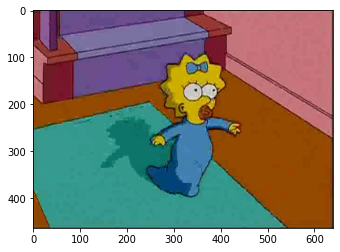

maggie simpson


In [ ]:
name  = 'pic_0105.jpg'
image = '/content/Extra_Images/'
image = '/content/characters/maggie_simpson/'

new_model = keras.models.load_model('New.h5')
predictions = plot_and_predict(image + name, new_model, pic_size=64)
print(map_characters[np.argmax(predictions[0])].replace('_',' '))